In [1]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 100
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.95  # precentage of train data from total

image_height = 32
image_width  = 32

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/"
data_dir = "/home/user/Robotics/Data_sets/slip_detection/will_dataset/formated_data/"
################################# CHANGE THIS!!!!  #################################

In [2]:
class BatchGenerator:
    def __init__(self):
        self.data_dir = data_dir
        data_map = []
        with open(data_dir + 'map.csv', 'r') as f:  # rb
            reader = csv.reader(f)
            for row in reader:
                data_map.append(row)

        if len(data_map) <= 1: # empty or only header
            print("No file map found")
            exit()

        self.data_map = data_map

    def load_full_data(self):
        dataset_train = FullDataSet(self.data_dir, self.data_map, type_="train")
        dataset_valid = FullDataSet(self.data_dir, self.data_map, type_="valid")
        dataset_test = FullDataSet(self.data_dir, self.data_map, type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

class FullDataSet():
    def __init__(self, data_dir, data_map, type_="train"):
        if type_ == "train":
            self.samples = data_map[1:int(len(data_map)*test_train_split)]
        elif type_ == "valid":
            self.samples = data_map[int(len(data_map)*(valid_train_split)):int(len(data_map)*test_train_split)]
        elif type_ == "test":
            self.samples = data_map[int(len(data_map)*test_train_split):-1]
        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        # neet to scale between 0 and 1:
        value = self.samples[idx]
        robot = np.load(data_dir + value[0])
        robot = (robot+1)/2
        xela1image = np.load(data_dir + value[1])
        xela1image = (xela1image+1)/2
        experiment = np.load(data_dir + value[-2])
        time_step  = np.load(data_dir + value[-1])     
        return([robot.astype(np.float32),
                xela1image.astype(np.float32),
                experiment,
                time_step])

In [3]:
import torch
from torch import nn
import torch.nn.functional as f
from torch.autograd import Variable

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim, out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size, padding=self.padding, bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device).to(device))

# initial test:
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.convlstm1 = ConvLSTMCell(input_dim=3, hidden_dim=12, kernel_size=(3, 3), bias=True).cuda()
        self.convlstm2 = ConvLSTMCell(input_dim=24, hidden_dim=24, kernel_size=(3, 3), bias=True).cuda()
        self.conv1 = nn.Conv2d(in_channels=24, out_channels=3, kernel_size=5, stride=1, padding=2).cuda()

    def forward(self, tactiles, actions):
        self.batch_size = actions.shape[1]
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        hidden_1, cell_1 = self.convlstm1.init_hidden(batch_size=self.batch_size, image_size=(32, 32))
        hidden_2, cell_2 = self.convlstm2.init_hidden(batch_size=self.batch_size, image_size=(32, 32))
        outputs = []
        for index, (sample_tactile, sample_action) in enumerate(zip(tactiles.squeeze(), actions.squeeze())):
            sample_tactile.to(device)
            sample_action.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                hidden_1, cell_1 = self.convlstm1(input_tensor=output, cur_state=[hidden_1, cell_1])
                state_action = torch.cat((state, sample_action), 1)
                robot_and_tactile = torch.cat((torch.cat(32*[torch.cat(32*[state_action.unsqueeze(2)], axis = 2).unsqueeze(3)], axis = 3), hidden_1.squeeze()), 1)
                hidden_2, cell_2 = self.convlstm2(input_tensor=robot_and_tactile, cur_state=[hidden_2, cell_2])
                output = self.conv1(hidden_2)
                outputs.append(output)
            else:
                hidden_1, cell_1 = self.convlstm1(input_tensor=sample_tactile, cur_state=[hidden_1, cell_1])
                state_action = torch.cat((state, sample_action), 1)
                robot_and_tactile = torch.cat((torch.cat(32*[torch.cat(32*[state_action.unsqueeze(2)], axis = 2).unsqueeze(3)], axis = 3), hidden_1.squeeze()), 1)
                hidden_2, cell_2 = self.convlstm2(input_tensor=robot_and_tactile, cur_state=[hidden_2, cell_2])
                output = self.conv1(hidden_2)
        return torch.stack(outputs)

In [11]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].squeeze().permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,4,3,2).to(device)
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                ground_truth = tactile[context_frames:]
                loss = self.criterion(tactile_predictions.to(device)[:,:,:48], ground_truth[:,:,:48])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].squeeze().permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,4,3,2).to(device)
                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action) # Step 3. Run our forward pass.                    
                    ground_truth = tactile[context_frames:]
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions.to(device), ground_truth)
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    print("saving model")
                    torch.save(self.full_model, model_path + "conv_model")
                    self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")
        plt.savefig(model_path + '/conv_model.png', dpi=300)
        plt.show()
        np.save(model_path + 'conv_model_training_loss', np.asarray(plot_training_loss))
        np.save(model_path + 'conv_model_validation_loss', np.asarray(plot_validation_loss))

In [12]:
## create data generator, train model and save model.
BG = BatchGenerator()
MT = ModelTrainer()
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "conv_model")
model = torch.load(model_path + "conv_model")
model.eval()
print("saved the model")
model = torch.load(model_path + "conv_model")
model.eval()

epoch: 0, loss: 0.0215, mean loss: 0.0330, :   1%|          | 1616/161500 [18:39<800:59:46, 18.04s/it]

Validation mean loss: 0.0180, 
saving model


epoch: 1, loss: 0.0128, mean loss: 0.0166, :   2%|▏         | 3231/161500 [36:00<25:01:26,  1.76it/s] 

Validation mean loss: 0.0132, 
saving model


epoch: 2, loss: 0.0163, mean loss: 0.0150, :   3%|▎         | 4846/161500 [54:41<25:10:42,  1.73it/s] 

Validation mean loss: 0.0141, 


epoch: 3, loss: 0.0129, mean loss: 0.0139, :   4%|▍         | 6461/161500 [1:14:16<29:22:18,  1.47it/s]

Validation mean loss: 0.0121, 
saving model


epoch: 4, loss: 0.0170, mean loss: 0.0131, :   5%|▌         | 8076/161500 [1:33:40<25:27:37,  1.67it/s]  

Validation mean loss: 0.0107, 
saving model


epoch: 5, loss: 0.0118, mean loss: 0.0124, :   6%|▌         | 9691/161500 [1:52:26<24:29:23,  1.72it/s] 

Validation mean loss: 0.0108, 


epoch: 6, loss: 0.0096, mean loss: 0.0121, :   7%|▋         | 11306/161500 [2:11:51<27:08:12,  1.54it/s] 

Validation mean loss: 0.0110, 


epoch: 7, loss: 0.0126, mean loss: 0.0116, :   8%|▊         | 12921/161500 [2:30:52<26:00:47,  1.59it/s] 

Validation mean loss: 0.0101, 
saving model


epoch: 8, loss: 0.0107, mean loss: 0.0114, :   9%|▉         | 14536/161500 [2:50:09<24:11:30,  1.69it/s] 

Validation mean loss: 0.0091, 
saving model


epoch: 9, loss: 0.0069, mean loss: 0.0111, :  10%|█         | 16151/161500 [3:09:21<23:55:25,  1.69it/s] 

Validation mean loss: 0.0093, 


epoch: 10, loss: 0.0129, mean loss: 0.0107, :  11%|█         | 17766/161500 [3:28:47<22:58:11,  1.74it/s]  

Validation mean loss: 0.0088, 
saving model


epoch: 11, loss: 0.0096, mean loss: 0.0106, :  12%|█▏        | 19381/161500 [3:47:58<25:12:43,  1.57it/s] 

Validation mean loss: 0.0083, 
saving model


epoch: 12, loss: 0.0114, mean loss: 0.0103, :  13%|█▎        | 20996/161500 [4:06:59<23:46:13,  1.64it/s] 

Validation mean loss: 0.0089, 


epoch: 13, loss: 0.0105, mean loss: 0.0100, :  14%|█▍        | 22611/161500 [4:26:22<25:17:02,  1.53it/s] 

Validation mean loss: 0.0092, 


epoch: 14, loss: 0.0101, mean loss: 0.0099, :  15%|█▌        | 24226/161500 [4:45:56<22:37:03,  1.69it/s] 

Validation mean loss: 0.0086, 
saving model


epoch: 15, loss: 0.0090, mean loss: 0.0097, :  16%|█▌        | 25841/161500 [5:04:33<21:29:52,  1.75it/s] 

Validation mean loss: 0.0085, 
saving model


epoch: 16, loss: 0.0088, mean loss: 0.0095, :  17%|█▋        | 27456/161500 [5:23:11<21:28:43,  1.73it/s] 

Validation mean loss: 0.0095, 


epoch: 17, loss: 0.0072, mean loss: 0.0093, :  18%|█▊        | 29071/161500 [5:41:27<23:15:26,  1.58it/s] 

Validation mean loss: 0.0081, 
saving model


epoch: 18, loss: 0.0099, mean loss: 0.0091, :  19%|█▉        | 30686/161500 [6:00:29<22:07:16,  1.64it/s] 

Validation mean loss: 0.0080, 
saving model


epoch: 19, loss: 0.0078, mean loss: 0.0089, :  20%|██        | 32301/161500 [6:19:44<21:33:58,  1.66it/s] 

Validation mean loss: 0.0079, 
saving model


epoch: 20, loss: 0.0106, mean loss: 0.0088, :  21%|██        | 33916/161500 [6:38:26<20:20:45,  1.74it/s] 

Validation mean loss: 0.0074, 
saving model


epoch: 21, loss: 0.0074, mean loss: 0.0087, :  22%|██▏       | 35531/161500 [6:56:43<20:41:45,  1.69it/s] 

Validation mean loss: 0.0073, 
saving model


epoch: 22, loss: 0.0077, mean loss: 0.0085, :  23%|██▎       | 37146/161500 [7:15:00<20:27:08,  1.69it/s] 

Validation mean loss: 0.0073, 
saving model


epoch: 23, loss: 0.0104, mean loss: 0.0096, :  24%|██▍       | 38761/161500 [7:33:18<20:08:12,  1.69it/s] 

Validation mean loss: 0.0075, 


epoch: 24, loss: 0.0071, mean loss: 0.0084, :  25%|██▌       | 40376/161500 [7:51:53<20:14:31,  1.66it/s] 

Validation mean loss: 0.0073, 
saving model


epoch: 25, loss: 0.0102, mean loss: 0.0084, :  26%|██▌       | 41991/161500 [8:10:58<20:07:45,  1.65it/s] 

Validation mean loss: 0.0073, 
saving model


epoch: 26, loss: 0.0083, mean loss: 0.0084, :  27%|██▋       | 43606/161500 [8:29:32<18:53:41,  1.73it/s] 

Validation mean loss: 0.0073, 
saving model


epoch: 27, loss: 0.0074, mean loss: 0.0084, :  28%|██▊       | 45221/161500 [8:48:08<18:46:51,  1.72it/s] 

Validation mean loss: 0.0071, 
saving model


epoch: 28, loss: 0.0066, mean loss: 0.0089, :  29%|██▉       | 46836/161500 [9:13:05<41:08:32,  1.29s/it] 

Validation mean loss: 0.0073, 


epoch: 29, loss: 0.0089, mean loss: 0.0082, :  30%|███       | 48451/161500 [9:38:19<18:12:39,  1.72it/s] 

Validation mean loss: 0.0072, 
saving model


epoch: 30, loss: 0.0077, mean loss: 0.0082, :  31%|███       | 50066/161500 [9:57:17<19:29:14,  1.59it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 31, loss: 0.0104, mean loss: 0.0083, :  32%|███▏      | 51681/161500 [10:16:54<17:49:30,  1.71it/s]

Validation mean loss: 0.0071, 


epoch: 32, loss: 0.0074, mean loss: 0.0085, :  33%|███▎      | 53296/161500 [10:36:44<24:35:28,  1.22it/s] 

Validation mean loss: 0.0071, 
saving model


epoch: 33, loss: 0.0081, mean loss: 0.0081, :  34%|███▍      | 54911/161500 [10:56:35<17:33:04,  1.69it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 34, loss: 0.0086, mean loss: 0.0082, :  35%|███▌      | 56526/161500 [11:16:30<18:12:21,  1.60it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 35, loss: 0.0067, mean loss: 0.0083, :  36%|███▌      | 58141/161500 [11:36:14<16:48:34,  1.71it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 36, loss: 0.0083, mean loss: 0.0082, :  37%|███▋      | 59756/161500 [11:55:24<16:19:11,  1.73it/s] 

Validation mean loss: 0.0070, 


epoch: 37, loss: 0.0075, mean loss: 0.0080, :  38%|███▊      | 61371/161500 [12:14:39<17:54:23,  1.55it/s] 

Validation mean loss: 0.0070, 
saving model


epoch: 38, loss: 0.0069, mean loss: 0.0082, :  39%|███▉      | 62986/161500 [12:34:02<16:43:58,  1.64it/s] 

Validation mean loss: 0.0072, 


epoch: 39, loss: 0.0081, mean loss: 0.0083, :   0%|          | 39/161500 [12:47:53<52984:48:44, 1181.37s/it]


KeyboardInterrupt: 

In [6]:
# test model on the full test sample:
# test model on the full test sample:
model = torch.load(model_path + "conv_model")
model.eval()
BG = BatchGenerator()
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()

test_lossesMAE_x = 0.0
test_lossesMSE_x = 0.0
test_lossesMAE_y = 0.0
test_lossesMSE_y = 0.0
test_lossesMAE_z = 0.0
test_lossesMSE_z = 0.0

test_lossesMAE_t1 = 0.0
test_lossesMSE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMSE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMSE_t10 = 0.0

test_lossesMAE_x_ts1 = 0.0
test_lossesMSE_x_ts1 = 0.0
test_lossesMAE_y_ts1 = 0.0
test_lossesMSE_y_ts1 = 0.0
test_lossesMAE_z_ts1 = 0.0
test_lossesMSE_z_ts1 = 0.0

test_lossesMAE_x_ts5 = 0.0
test_lossesMSE_x_ts5 = 0.0
test_lossesMAE_y_ts5 = 0.0
test_lossesMSE_y_ts5 = 0.0
test_lossesMAE_z_ts5 = 0.0
test_lossesMSE_z_ts5 = 0.0

test_lossesMAE_x_ts10 = 0.0
test_lossesMSE_x_ts10 = 0.0
test_lossesMAE_y_ts10 = 0.0
test_lossesMSE_y_ts10 = 0.0
test_lossesMAE_z_ts10 = 0.0
test_lossesMSE_z_ts10 = 0.0

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:                    
        action = batch_features[0].squeeze().permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,4,3,2).to(device)

        tp = model.forward(tactiles=tactile, actions=action)
        experiment_time_steps.append([batch_features[2], batch_features[3]])
        tactile_predictions.append(tp)  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tactile[context_frames:])
        # calculate losses for specific timesteps
        test_lossMAE_t1 = criterion1(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item() 
        test_lossMSE_t1 = criterion2(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMSE_t1 += test_lossMSE_t1.item() 
        test_lossMAE_t5 = criterion1(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item() 
        test_lossMSE_t5 = criterion2(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMSE_t5 += test_lossMSE_t5.item() 
        test_lossMAE_t10 = criterion1(tp[9,:,:].to(device), tactile[context_frames:][9,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item() 
        test_lossMSE_t10 = criterion2(tp[9,:,:].to(device), tactile[context_frames:][9,:,:])
        test_lossesMSE_t10 += test_lossMSE_t10.item() 
        
        # calculate losses for specific forces
        test_lossMAE_x = criterion1(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
        test_lossesMAE_x += test_lossMAE_x.item() 
        test_lossMSE_x = criterion2(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
        test_lossesMSE_x += test_lossMSE_x.item() 
        test_lossMAE_y = criterion1(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
        test_lossesMAE_y += test_lossMAE_y.item() 
        test_lossMSE_y = criterion2(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
        test_lossesMSE_y += test_lossMSE_y.item() 
        test_lossMAE_z = criterion1(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
        test_lossesMAE_z += test_lossMAE_z.item() 
        test_lossMSE_z = criterion2(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
        test_lossesMSE_z += test_lossMSE_z.item() 

        # calculate losses for specific timesteps and forces 
        test_lossMAE_x_ts1 = criterion1(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
        test_lossesMAE_x_ts1 += test_lossMAE_x_ts1.item() 
        test_lossMSE_x_ts1 = criterion2(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
        test_lossesMSE_x_ts1 += test_lossMSE_x_ts1.item() 
        test_lossMAE_y_ts1 = criterion1(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
        test_lossesMAE_y_ts1 += test_lossMAE_y_ts1.item() 
        test_lossMSE_y_ts1 = criterion2(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
        test_lossesMSE_y_ts1 += test_lossMSE_y_ts1.item() 
        test_lossMAE_z_ts1 = criterion1(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
        test_lossesMAE_z_ts1 += test_lossMAE_z_ts1.item() 
        test_lossMSE_z_ts1 = criterion2(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
        test_lossesMSE_z_ts1 += test_lossMSE_z_ts1.item() 
 
        test_lossMAE_x_ts5 = criterion1(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
        test_lossesMAE_x_ts5 += test_lossMAE_x_ts5.item() 
        test_lossMSE_x_ts5 = criterion2(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
        test_lossesMSE_x_ts5 += test_lossMSE_x_ts5.item() 
        test_lossMAE_y_ts5 = criterion1(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
        test_lossesMAE_y_ts5 += test_lossMAE_y_ts5.item() 
        test_lossMSE_y_ts5 = criterion2(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
        test_lossesMSE_y_ts5 += test_lossMSE_y_ts5.item() 
        test_lossMAE_z_ts5 = criterion1(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
        test_lossesMAE_z_ts5 += test_lossMAE_z_ts5.item() 
        test_lossMSE_z_ts5 = criterion2(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
        test_lossesMSE_z_ts5 += test_lossMSE_z_ts5.item() 

        test_lossMAE_x_ts10 = criterion1(tp[9,:,:16].to(device), tactile[context_frames:][9,:,:16])
        test_lossesMAE_x_ts10 += test_lossMAE_x_ts10.item() 
        test_lossMSE_x_ts10 = criterion2(tp[9,:,:16].to(device), tactile[context_frames:][9,:,:16])
        test_lossesMSE_x_ts10 += test_lossMSE_x_ts10.item() 
        test_lossMAE_y_ts10 = criterion1(tp[9,:,17:32].to(device), tactile[context_frames:][9,:,17:32])
        test_lossesMAE_y_ts10 += test_lossMAE_y_ts10.item() 
        test_lossMSE_y_ts10 = criterion2(tp[9,:,17:32].to(device), tactile[context_frames:][9,:,17:32])
        test_lossesMSE_y_ts10 += test_lossMSE_y_ts10.item() 
        test_lossMAE_z_ts10 = criterion1(tp[9,:,33:48].to(device), tactile[context_frames:][9,:,33:48])
        test_lossesMAE_z_ts10 += test_lossMAE_z_ts10.item() 
        test_lossMSE_z_ts10 = criterion2(tp[9,:,33:48].to(device), tactile[context_frames:][9,:,33:48])
        test_lossesMSE_z_ts10 += test_lossMSE_z_ts10.item()

performance_data = []
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_x / index__)])
performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_x / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_y / index__)])
performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_y / index__)])
performance_data.append(["test loss MAE(L1) timestep 10: ", (test_lossesMAE_z / index__)])
performance_data.append(["test loss MSE timestep 10: ", (test_lossesMSE_z / index__)])
performance_data.append(["sheer x test loss MAE(L1): ", (test_lossesMAE_x / index__)])
performance_data.append(["sheer x test loss MSE: ", (test_lossesMSE_x / index__)])
performance_data.append(["sheer y test loss MAE(L1): ", (test_lossesMAE_y / index__)])
performance_data.append(["sheer y test loss MSE: ", (test_lossesMSE_y / index__)])
performance_data.append(["z test loss MAE(L1): ", (test_lossesMAE_z / index__)])
performance_data.append(["z test loss MSE: ", (test_lossesMSE_z / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 1: ", (test_lossesMAE_x_ts1 / index__)])
performance_data.append(["sheer x test loss MSE timestep 1: ", (test_lossesMSE_x_ts1 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 1: ", (test_lossesMAE_y_ts1 / index__)])
performance_data.append(["sheer y test loss MSE timestep 1: ", (test_lossesMSE_y_ts1 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 1: ", (test_lossesMAE_z_ts1 / index__)])
performance_data.append(["z test loss MSE timestep 1: ", (test_lossesMSE_z_ts1 / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 5: ", (test_lossesMAE_x_ts5 / index__)])
performance_data.append(["sheer x test loss MSE timestep 5: ", (test_lossesMSE_x_ts5 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 5: ", (test_lossesMAE_y_ts5 / index__)])
performance_data.append(["sheer y test loss MSE timestep 5: ", (test_lossesMSE_y_ts5 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 5: ", (test_lossesMAE_z_ts5 / index__)])
performance_data.append(["z test loss MSE timestep 5: ", (test_lossesMSE_z_ts5 / index__)])
performance_data.append(["sheer x test loss MAE(L1) timestep 10: ", (test_lossesMAE_x_ts10 / index__)])
performance_data.append(["sheer x test loss MSE timestep 10: ", (test_lossesMSE_x_ts10 / index__)])
performance_data.append(["sheer y test loss MAE(L1) timestep 10: ", (test_lossesMAE_y_ts10 / index__)])
performance_data.append(["sheer y test loss MSE timestep 10: ", (test_lossesMSE_y_ts10 / index__)])
performance_data.append(["z test loss MAE(L1) timestep 10: ", (test_lossesMAE_z_ts10 / index__)])
performance_data.append(["z test loss MSE timestep 10: ", (test_lossesMSE_z_ts10 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'pp_performance_data_conv_model', np.asarray(performance_data))
print("done")

['test loss MAE(L1): ', 0.0]
['test loss MSE: ', 0.0]
['test loss MAE(L1) timestep 1: ', 0.008943498133920088]
['test loss MSE timestep 1: ', 0.000548620423223107]
['test loss MAE(L1) timestep 5: ', nan]
['test loss MSE timestep 5: ', nan]
['test loss MAE(L1) timestep 10: ', nan]
['test loss MSE timestep 10: ', nan]
['sheer x test loss MAE(L1): ', 0.008943498133920088]
['sheer x test loss MSE: ', 0.000548620423223107]
['sheer y test loss MAE(L1): ', nan]
['sheer y test loss MSE: ', nan]
['z test loss MAE(L1): ', nan]
['z test loss MSE: ', nan]
['sheer x test loss MAE(L1) timestep 1: ', 0.002521950773717392]
['sheer x test loss MSE timestep 1: ', 0.00010302351423011455]
['sheer y test loss MAE(L1) timestep 1: ', nan]
['sheer y test loss MSE timestep 1: ', nan]
['z test loss MAE(L1) timestep 1: ', nan]
['z test loss MSE timestep 1: ', nan]
['sheer x test loss MAE(L1) timestep 5: ', 0.008768834083249593]
['sheer x test loss MSE timestep 5: ', 0.0004626285946427867]
['sheer y test loss MAE

/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t1_feature_0.gif


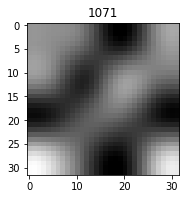

1
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t1_feature_1.gif


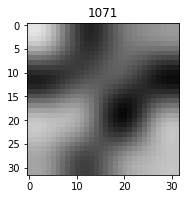

2
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t1_feature_2.gif


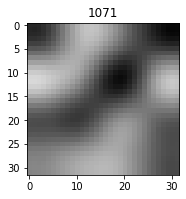

3
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t5_feature_0.gif


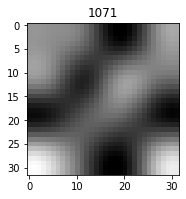

4
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t5_feature_1.gif


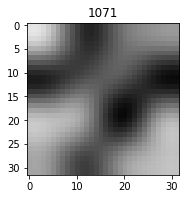

5
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t5_feature_2.gif


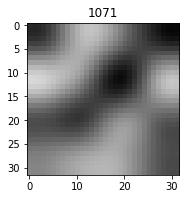

6
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t10_feature_0.gif


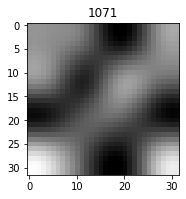

7
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t10_feature_1.gif


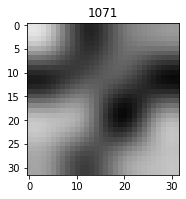

8
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_predicted_data_t10_feature_2.gif


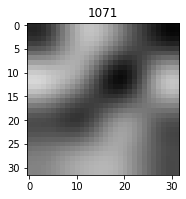

9
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_groundtruth_data_feature_0.gif


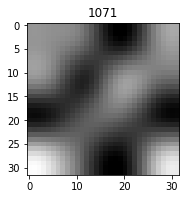

1
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_groundtruth_data_feature_1.gif


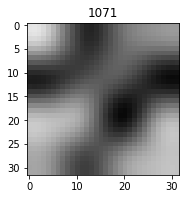

2
/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_002/210/pp_groundtruth_data_feature_2.gif


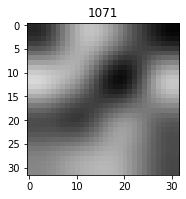

3


In [16]:
import matplotlib
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.ndimage.interpolation import map_coordinates

# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t10 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t10 = []
groundtruth_data = []
experiment_to_test = 210
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        experiment = experiment_time_steps[index][0][batch][0]
#         print(experiment)
        if experiment == experiment_to_test:
            prediction_values = batch_set[time_step_to_test_t1][batch]
            predicted_data_t1.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t5][batch]
            predicted_data_t5.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t10][batch]
            predicted_data_t10.append(prediction_values)
            gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
            groundtruth_data.append(gt_values)

# mse_loss = torch.nn.MSELoss()
# print("MAE timestep + 1: ", np.mean(np.asarray([mse_loss(np.asarray(pred.cpu().detach()), np.asarray(gt.cpu().detach()))  for pred, gt in zip(predicted_data_t1, groundtruth_data)])))
# print("MAE timestep + 5: ", mse_loss(torch.tensor(predicted_data_t5), torch.tensor(groundtruth_data)))
# print("MAE timestep + 10: ", mse_loss(torch.tensor(predicted_data_t10), torch.tensor(groundtruth_data)))
# model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/conv_model_001/"
class image_player():
    def __init__(self, images, save_name, feature):
        self.feature = feature
        self.save_name = save_name
        print(model_path + str(experiment_to_test) + '/' + self.save_name + '_feature_' + str(self.feature) + '.gif')
        self.run_the_tape(images)

    def grab_frame(self):
#         print(self.indexyyy,  end="\r")
#         print(self.images[0].shape)
        frame = self.images[self.indexyyy].permute(1,2,0).cpu().detach().numpy()[:,:,self.feature]*255
        return frame

    def update(self, i):
        plt.title(i)
        self.im1.set_data(self.grab_frame())
        self.indexyyy+=1
        if self.indexyyy == len(self.images):
            self.indexyyy = 0

    def run_the_tape(self, images):
        self.indexyyy = 0
        self.images = images
        ax1 = plt.subplot(1,2,1)
        self.im1 = ax1.imshow(self.grab_frame(), cmap='gray', vmin=0, vmax=255)
        ani = FuncAnimation(plt.gcf(), self.update, interval=20.8, save_count=len(images), repeat=False)
        ani.save(model_path + str(experiment_to_test) + '/' + self.save_name + '_feature_' + str(self.feature) + '.gif')
        plt.show()

image_player(predicted_data_t1, "pp_predicted_data_t1", 0)
print('1')
image_player(predicted_data_t1, "pp_predicted_data_t1", 1)
print('2')
image_player(predicted_data_t1, "pp_predicted_data_t1", 2)
print('3')
image_player(predicted_data_t5, "pp_predicted_data_t5", 0)
print('4')
image_player(predicted_data_t5, "pp_predicted_data_t5", 1)
print('5')
image_player(predicted_data_t5, "pp_predicted_data_t5", 2)
print('6')
image_player(predicted_data_t10, "pp_predicted_data_t10", 0)
print('7')
image_player(predicted_data_t10, "pp_predicted_data_t10", 1)
print('8')
image_player(predicted_data_t10, "pp_predicted_data_t10", 2)
print('9')
image_player(groundtruth_data, "pp_groundtruth_data", 0)
print('1')
image_player(groundtruth_data, "pp_groundtruth_data", 1)
print('2')
image_player(groundtruth_data, "pp_groundtruth_data", 2)
print('3')

#save numpy arrays for later analysis:
np_to_save = []
np_predicted_data_t1 = []
np_predicted_data_t5 = []
np_predicted_data_t10 = []
np_groundtruth_data = []
for i in range(0, len(predicted_data_t1)):
    np_predicted_data_t1.append(predicted_data_t1[i].permute(1,2,0).cpu().detach().numpy())
    np_predicted_data_t5.append(predicted_data_t5[i].permute(1,2,0).cpu().detach().numpy())
    np_predicted_data_t10.append(predicted_data_t10[i].permute(1,2,0).cpu().detach().numpy())
    np_groundtruth_data.append(groundtruth_data[i].permute(1,2,0).cpu().detach().numpy())
np.save(model_path + str(experiment_to_test) + '/pp_np_predicted_data_t1_conv_model', np.asarray(np_predicted_data_t1))
np.save(model_path + str(experiment_to_test) + '/pp_np_predicted_data_t5_conv_model', np.asarray(np_predicted_data_t5))
np.save(model_path + str(experiment_to_test) + '/pp_np_predicted_data_t10_conv_model', np.asarray(np_predicted_data_t10))
np.save(model_path + str(experiment_to_test) + '/pp_np_groundtruth_data_conv_model', np.asarray(np_groundtruth_data))

In [ ]:
# test model on the full test sample:
model = torch.load(model_path + "conv_model")
model.eval()

train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()




# model = MT.strongest_model

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()

test_lossesMAE_t1 = 0.0
test_lossesMSE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMSE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMSE_t10 = 0.0

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(MT.test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze().permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)):
            if scale_together == False:
                # tp:
                (tpx, tpy, tpz) = np.split(tp[i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                     xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                     xela_z_inverse_full), axis=1))
            else:            
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                # tactile_prediction_decoded = pca.inverse_transform(tactile_prediction_decoded)
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                # tactile_gt_decoded = pca.inverse_transform(tactile_gt_decoded)
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))

        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        ############ RESCALE THE DATA HERE ################
        
        tactile_predictions.append(tp_back_scaled)  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tg_back_scaled)
        # calculate losses for specific timesteps
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled).item()
        test_lossesMSE += criterion2(tp_back_scaled, tg_back_scaled).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[0,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMSE_t1 = criterion2(tp_back_scaled[0,:,:], tg_back_scaled[0,:,:])
        test_lossesMSE_t1 += test_lossMSE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[4,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMSE_t5 = criterion2(tp_back_scaled[4,:,:], tg_back_scaled[4,:,:])
        test_lossesMSE_t5 += test_lossMSE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[9,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
        test_lossMSE_t10 = criterion2(tp_back_scaled[9,:,:], tg_back_scaled[9,:,:])
        test_lossesMSE_t10 += test_lossMSE_t10.item()

performance_data = []
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 9: ", (test_lossesMAE_t10 / index__)])
performance_data.append(["test loss MSE timestep 9: ", (test_lossesMSE_t10 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'concat_td1skip_fixed_euler_performance_data', np.asarray(performance_data))

# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t9 = 5
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        prediction_values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(prediction_values)
        prediction_values = batch_set[time_step_to_test_t9][batch]
        predicted_data_t9.append(prediction_values)
        gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data.append(gt_values)  
print("done")